# **SMU Course Bidding Data Preprocessing V2**

### **Difference between V1 and V2**
- V1: Using readily available BOSS data found on OASIS.
- V2: Using scraped data from BOSS Bidding website on class and exam timings, locations, and grading basis.

### **Objective**
This notebook performs the following steps:
1. **Data Cleaning** - Handle redundant columns and remove unwanted data.
2. **Feature Engineering** - Create derived features.
3. **Exploratory Data Analysis (EDA)** - Analyze key features and correlations.
4. **Further Data Cleaning** - Removing high multicollinear variables.
5. **Save Processed Data** - Save the data into a csv that is useable for other ML models

### **Requirements**
- Python 3.x
- TensorFlow, Pandas, NumPy, Matplotlib, Seaborn, Sklearn

---

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set up folder path containing all Excel files
data_folder = 'overallBossResultsWTimings'
data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]

# Load and combine data
dataframes = [pd.read_csv(file) for file in data_files]
data = pd.concat(dataframes, ignore_index=True)

# Basic data checks
print(f"Loaded {len(data_files)} files.")
print("Initial Data Shape:", data.shape)
print(data.head())

Loaded 12 files.
Initial Data Shape: (121221, 29)
             Term                   Session     Bidding Window Course Code  \
0  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT001   
1  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT009   
2  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
3  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
4  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   

                                         Description Section  Vacancy  \
0  Accounting Study Mission (Asian Studies)(Bangkok)      G1       45   
1  Overseas Project Experience (Accounting in Asi...      G1       25   
2                               Financial Accounting      G1       42   
3                               Financial Accounting     G10       45   
4                               Financial Accounting     G11       45   

   Opening Vacancy  Before Process Vacancy


---
## 1. Data Cleaning

Steps:
1. Remove rows where 'Min Bid' is 0.
2. Drop redundant columns:
    - `Session`
    - `D.I.C.E`
    - `School/Department`
    - `Opening Vacancy`
3. Handle missing values (if any).
    

In [3]:
# Data Cleaning
# 1. Remove rows where 'Min Bid' == 0
data = data[data['Min Bid'] != 0]

# 2. Drop redundant columns
columns_to_drop = ['Session', 'D.I.C.E', 'School/Department', 'Opening Vacancy']
data = data.drop(columns=columns_to_drop, errors='ignore')

# 3. Handle missing values
data['Instructor'] = data['Instructor'].fillna("Not Assigned Yet")

# Fill empty or "TBA" values in specific columns with "NA"
columns_with_na = [
    'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue', 
    'class2_day', 'class2_starttime', 'class2_venue', 
    'class3_day', 'class3_starttime', 'class3_venue', 
    'exam_startdate', 'exam_day', 'exam_starttime'
]

for col in columns_with_na:
    # Replace empty strings, NaN, or "TBA" with "NA"
    data[col] = data[col].replace(["", "TBA", None], "NA")

In [4]:
print(f"Data after cleaning categorical columns:")
print(data[columns_with_na].head())

Data after cleaning categorical columns:
   Grading Basis class1_day class1_starttime          class1_venue class2_day  \
45        Graded        Wed            15:30  SOA Seminar Room 3-5         NA   
64        Graded        Mon            08:15  SOA Seminar Room 3-5         NA   
65        Graded        Mon            15:30  SOA Seminar Room 3-5         NA   
73        Graded        Thu            12:00  SOA Seminar Room 3-1         NA   
96        Graded        Thu            19:00   LKCSB Classroom 2-1         NA   

   class2_starttime class2_venue class3_day class3_starttime class3_venue  \
45               NA           NA         NA               NA           NA   
64               NA           NA         NA               NA           NA   
65               NA           NA         NA               NA           NA   
73               NA           NA         NA               NA           NA   
96               NA           NA         NA               NA           NA   

   exam_s


---
## 2. Feature Engineering

Steps:
1. Create `AY` and `Term` columns from `Term` column.
2. Transform `Bidding Window` into `Round` and `Window`.
3. Split `Course Code` into `SubjectArea` and `CatalogueNo`.
4. Perform embeddings for text and categorical columns:
    - `Description`, `SubjectArea`, `Section`, `Instructor`
5. Create derived columns:
    - `BidderCount`: `Before Process Vacancy` - `After Process Vacancy`
    - `CurrEnrolledCount`: `Enrolled Students` - `BidderCount`
    

In [5]:
# Feature Engineering
# Extract AY and Term
data['AY'] = data['Term'].str[:4]
data['Term'] = data['Term'].str.split('Term ', expand=True)[1].str.strip()

# Extract Round and Window from 'Bidding Window'
data['Round'] = data['Bidding Window'].str.extract(r'Round (\d[A-B]?)')
data['Window'] = data['Bidding Window'].str.extract(r'Window (\d)')

# Extract SubjectArea and CatalogueNo from 'Course Code'
data['SubjectArea'] = data['Course Code'].str.extract(r'([A-Za-z-]+)')
data['CatalogueNo'] = data['Course Code'].str.extract(r'(\d+)$')

# Create BidderCount and CurrEnrolledCount
data['BidderCount'] = data['Before Process Vacancy'] - data['After Process Vacancy']
data['CurrEnrolledCount'] = data['Enrolled Students'] - data['BidderCount']

# Drop columns used for derived features
data = data.drop(columns=['Bidding Window', 'Course Code', 'Before Process Vacancy', 
                          'After Process Vacancy', 'Enrolled Students'], errors='ignore')

# After extracting AY and Window from strings, convert them to numeric
data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
data['Window'] = pd.to_numeric(data['Window'], errors='coerce')

# Round 2A has no window, thus has to be assigned -1
data['Window'] = data['Window'].fillna(-1).astype(int)

# Manual mapping for Term
# Term dropdown: 1, 2, 3A, 3B
term_map = {
    '1': 1,
    '2': 2,
    '3A': 3,
    '3B': 4
}

data['Term'] = data['Term'].map(term_map)

# Manual mapping for Round
# Round dropdown: 1, 1A, 1B, 1C, 2, 2A
round_map = {
    '1': 1,
    '1A': 2,
    '1B': 3,
    '1C': 4,
    '2': 5,
    '2A': 6
}

data['Round'] = data['Round'].map(round_map)

print("Data after Cleaning and Feature Engineering:")
print(data.head())
print(data.info())

Data after Cleaning and Feature Engineering:
    Term                       Description Section  Vacancy  Median Bid  \
45     2  Financial Reporting and Analysis      G3       42       25.00   
64     2                         Valuation      G1       42       10.09   
65     2                         Valuation      G2       42       10.03   
73     2    Auditing for the Public Sector      G1       42       25.00   
96     2          Public Relations Writing      G1       45       10.00   

    Min Bid            Instructor Grading Basis class1_day class1_starttime  \
45    25.00          GOH BENG WEE        Graded        Wed            15:30   
64    10.09        CHENG NAM SANG        Graded        Mon            08:15   
65    10.00        CHENG NAM SANG        Graded        Mon            15:30   
73    25.00          LIM SOO PING        Graded        Thu            12:00   
96    10.00   YASMIN HANNAH RAMLE        Graded        Thu            19:00   

    ... exam_startdate exam_d


---
## 3. Exploratory Data Analysis (EDA)

### Steps:
1. Explore statistics and distributions of all variables.
2. Perform corrleation heatmap on numerical variables. Perform feature selection afterwards to remove high multicollinear variables.


### Descriptive statistics

In [6]:
# 1. Print descriptive statistics for all columns
print("=== Descriptive Statistics (All Columns) ===")
display(data.describe(include='all'))

=== Descriptive Statistics (All Columns) ===


,Term,Description,Section,Vacancy,Median Bid,Min Bid,Instructor,Grading Basis,class1_day,class1_starttime,...,exam_startdate,exam_day,exam_starttime,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount,CurrEnrolledCount
count,36718.000000,36718,36718,36718.000000,36718.000000,36718.000000,36718,36718,36718,36718,...,36718,36718,36718,36718.000000,31601.000000,36718.000000,36718,36718,36718.000000,36718.000000
unique,NaN,668,45,NaN,NaN,NaN,931,3,8,11,...,83,7,4,NaN,NaN,NaN,55,373,NaN,NaN
top,NaN,Management Communication,G1,NaN,NaN,NaN,Not Assigned Yet,Graded,Tue,12:00,...,NA,NA,NA,NaN,NaN,NaN,COR,101,NaN,NaN
freq,NaN,1394,14491,NaN,NaN,NaN,516,31562,7168,10423,...,13806,13806,13806,NaN,NaN,NaN,5469,2785,NaN,NaN
mean,1.550874,NaN,NaN,43.654611,29.110291,24.532293,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022.612642,2.657542,1.152650,NaN,NaN,6.335884,26.779018
std,0.504372,NaN,NaN,40.209872,20.306400,19.353522,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.011167,1.596197,1.043037,NaN,NaN,9.589741,15.328644
min,1.000000,NaN,NaN,1.000000,10.000000,10.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021.000000,1.000000,-1.000000,NaN,NaN,-2.000000,-2.000000
25%,1.000000,NaN,NaN,45.000000,15.350000,10.502500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2022.000000,1.000000,1.000000,NaN,NaN,1.000000,16.000000
50%,2.000000,NaN,NaN,45.000000,24.820000,18.460000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023.000000,2.000000,1.000000,NaN,NaN,2.000000,32.000000
75%,2.000000,NaN,NaN,45.000000,36.000000,30.890000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023.000000,3.000000,2.000000,NaN,NaN,6.000000,40.000000


### Outlier fixing

1. There are three rows affected with vacancy of 4445. Replace with 45.

In [7]:
# Replace all rows where Vacancy is 4445 with 45
data.loc[data['Vacancy'] == 4445, 'Vacancy'] = 45

2. Min bid prices for certain classes are high because of troll bidding / graduation.

- This is likely caused by people who bidded by themselves only. We can remove these rows as they skew the model and is not representative of majority of the cases.

In [8]:
data['Min Bid'].describe()

count    36718.000000
mean        24.532293
std         19.353522
min         10.000000
25%         10.502500
50%         18.460000
75%         30.890000
max        354.580000
Name: Min Bid, dtype: float64

In [9]:
iqrMinBid = data['Min Bid'].quantile(0.75) - data['Min Bid'].quantile(0.25)
outlierThresholdMinBid = data['Min Bid'].quantile(0.75) + iqrMinBid * 1.5

In [10]:
outlierThresholdMinBid

61.471250000000005

In [11]:
dropOutliersMinBid = data[(data['Min Bid']>=outlierThresholdMinBid)]
dropOutliersMinBid

,Term,Description,Section,Vacancy,Median Bid,Min Bid,Instructor,Grading Basis,class1_day,class1_starttime,...,exam_startdate,exam_day,exam_starttime,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount,CurrEnrolledCount
604,2,Introduction to Programming,G3,44,72.37,72.37,MICHELLE KAN,Graded,Wed,15:30,...,19-Apr-2022,Tue,13:00,2021,6.0,3,IS,111,1,42
1833,2,Overseas Project Experience (Law in Asia)(SMU-...,G1,27,76.00,76.00,PASHA HSIEH,Pass/Fail,Thu,15:30,...,NA,NA,NA,2021,6.0,2,LAW,4025,1,26
1879,2,Topics in Financial Crime,G1,34,80.50,80.50,"JIANG KE-YUE, KEVIN YONG, LEONG WENG TAT",Graded,Tue,19:00,...,26-Apr-2022,Tue,08:30,2021,6.0,2,LAW,487,1,29
2086,2,Chinese Foreign Policy,G2,45,92.00,92.00,FRANCES YAPING WANG,Graded,Wed,19:00,...,NA,NA,NA,2021,6.0,2,POSC,222,1,38
2495,2,"Refocusing Wealth and Poverty: Relations, Form...",G1,45,90.01,90.01,"AIDAN WONG, GIOVANNI KO",Graded,Thu,15:30,...,NA,NA,NA,2021,6.0,1,COR,2628,1,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121038,2,The Design of Business(SMU-X),G4,45,140.86,128.88,ADAM GERARD,Graded,Tue,15:30,...,NA,NA,NA,2024,1.0,1,MGMT,330,38,0
121039,2,The Design of Business(SMU-X),G5,45,130.00,122.91,ADAM GERARD,Graded,Wed,15:30,...,NA,NA,NA,2024,1.0,1,MGMT,330,38,0
121040,2,The Design of Business(SMU-X),G6,45,145.55,126.31,JOSEPHINE KANG POH TIN,Graded,Wed,19:00,...,NA,NA,NA,2024,1.0,1,MGMT,330,37,1
121042,2,The Design of Business(SMU-X),G8,45,97.50,80.52,JOHN ANTONY,Graded,Fri,08:15,...,NA,NA,NA,2024,1.0,1,MGMT,330,10,0


In [12]:
data = data.drop(dropOutliersMinBid.index)

In [13]:
print(f"Removed {len(dropOutliersMinBid)} rows where 'Min Bid' >= {outlierThresholdMinBid} and 'BidderCount' == 1.")

Removed 1531 rows where 'Min Bid' >= 61.471250000000005 and 'BidderCount' == 1.


In [14]:
data['Min Bid'].describe()

count    35187.000000
mean        21.761790
std         12.852655
min         10.000000
25%         10.200000
50%         17.120000
75%         30.000000
max         61.450000
Name: Min Bid, dtype: float64

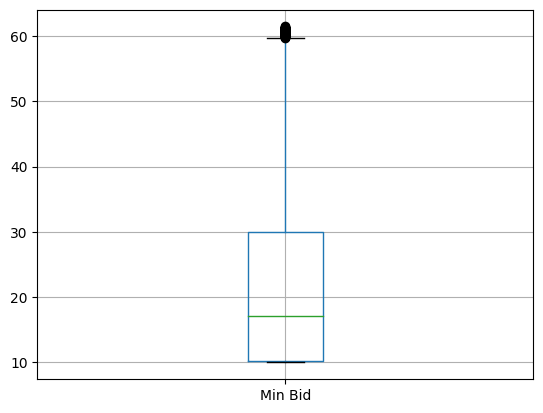

In [15]:
data.boxplot(column=['Min Bid'])
plt.show()

### Correlation heatmap

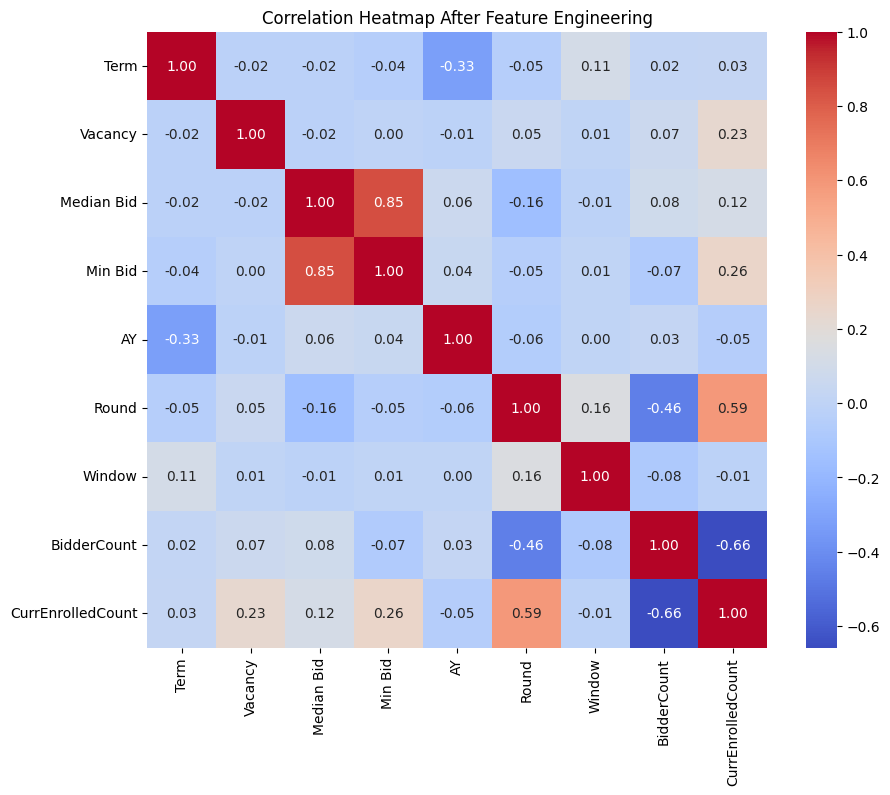

In [16]:
# Check distributions and correlations post feature engineering
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap After Feature Engineering")
plt.show()


---
## 4. Further data cleaning

### Steps:
1. Remove redundant variable - Median Bid
2. Remove derived variable - CurrEnrolledCount

In [17]:
additional_columns_to_drop = ['Median Bid', 'CurrEnrolledCount']
data = data.drop(columns=additional_columns_to_drop)


---
## 5. Save data into CSV
    

In [19]:
# Save the transformed data to a CSV file
output_path = 'transformed_data_w_timings.csv'
data.to_csv(output_path, index=False)
print(f"Data successfully saved to {output_path}")

Data successfully saved to transformed_data_w_timings.csv
